# Men's Olympic 100m winning times
This notebook illustrates the implementation of least squares to find the unknown parameters of a linear regressor given the training data

In [15]:
using Plots
using LinearAlgebra
using DataFrames
using StatsPlots
using CSV

In [16]:
data_folder = "./data/"

"./data/"

In [3]:
# 1- Data loading
file_path = joinpath(data_folder, "olympics_100m.csv")  # Construct the full file path

# Read the CSV file using DataFrames
ds = DataFrame(CSV.File(file_path))

# Splitting training/test
n = size(ds, 1)
training = ds[1:n-2, :]
testing = ds[n-1:end, :]

# Let's use the notation from the lecture
X = training[:, "Year"]
y = training[:, "Time"]
X = reshape(X, length(X), 1)  # Reshape X to a 2D array
@show X;

X = [1896; 1900; 1904; 1908; 1912; 1920; 1924; 1928; 1932; 1936; 1948; 1952; 1956; 1960; 1964; 1968; 1972; 1976; 1980; 1984; 1988; 1992; 1996; 2000; 2004; 2008; 2012;;]


In [4]:
function polynomial_features(X, degree)
    n_samples, n_features = size(X)
    
    # Initialize an empty matrix for the polynomial features
    poly_features = ones(n_samples, 1)
    
    # Generate polynomial features up to the specified degree
    for d = 1:degree
        for feature = 1:n_features
            poly_features = hcat(poly_features, X[:, feature].^d)
        end
    end

    return poly_features
end

polynomial_features (generic function with 1 method)

In [5]:
degree = 1       # Specify the degree of the polynomial

# Create polynomial features
X = polynomial_features(X, degree)

# Display the result
@show X;

X = [1.0 1896.0; 1.0 1900.0; 1.0 1904.0; 1.0 1908.0; 1.0 1912.0; 1.0 1920.0; 1.0 1924.0; 1.0 1928.0; 1.0 1932.0; 1.0 1936.0; 1.0 1948.0; 1.0 1952.0; 1.0 1956.0; 1.0 1960.0; 1.0 1964.0; 1.0 1968.0; 1.0 1972.0; 1.0 1976.0; 1.0 1980.0; 1.0 1984.0; 1.0 1988.0; 1.0 1992.0; 1.0 1996.0; 1.0 2000.0; 1.0 2004.0; 1.0 2008.0; 1.0 2012.0]


In [6]:
include("ops.jl")

findmax (generic function with 10 methods)

Now, let's compute the weights using the least squares method:

$\mathbf{\hat{w}}=(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{y}$

In [7]:
ŵ = ((X)ᵀ * X)⁻¹ * (X)ᵀ * y 
println("Weights: ", ŵ)

Weights: [35.77145619588415, -0.0130037735192905]


Let's estimate the mean squared error (MSE) and the residual sum-of-squares (RSS):

In [8]:
# Calculate ŷ
ŷ = ∑( X * ŵ, dims=2 )

# Calculate RSS
RSS = ∑((y .- ŷ) .^ 2)

# Calculate MSE
MSE = RSS / nrow(training)

# Print RSS and MSE
println("RSS: ", RSS, "\nMSE: ", MSE)

RSS: 1.304203366605224
MSE: 0.048303828392786075


Now, let's predict the times of 2016 and 2020 

*Note:* Olympics were held in 2021.

In [10]:
# Extract and preprocess the test data
X_test = testing[:, "Year"]
y_test = testing[:, "Time"]
X_test = reshape(X_test, length(X_test), 1) # 
@show X_test;

degree = 1       # Specify the degree of the polynomial

# Create polynomial features
X_test = polynomial_features(X_test, degree) # Apply the same PolynomialFeatures transformation

# Display the result
@show X_test;

# Calculate ŷ_test
ŷ_test = ∑( X_test * ŵ, dims=2 )


# Calculate MSE for the test data
MSE_test = sum((y_test .- ŷ_test) .^ 2) / nrow(testing)

X_test = [2016; 2020;;]
X_test = [1.0 2016.0; 1.0 2020.0]


0.07615366356347843

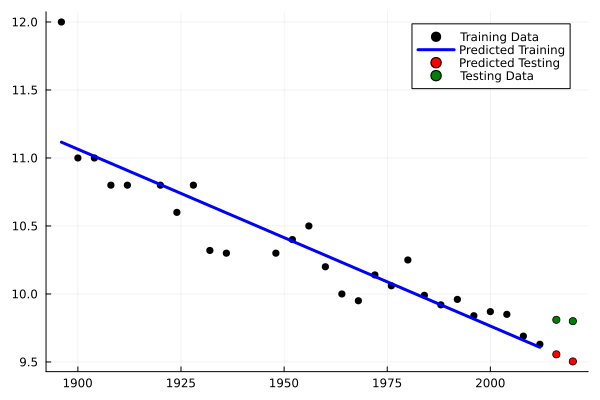

In [11]:
using Plots

# Set the size of the figure
default(size=(600, 400))

# Scatter plot for training data
scatter(X[:, 2], y, color="black", label="Training Data")

# Line plot for the predicted values on training data
plot!(X[:, 2], ŷ, color="blue", linewidth=3, label="Predicted Training")

# Scatter plot for testing data and predictions
scatter!(X_test[:, 2], ŷ_test, color="red", label="Predicted Testing")
scatter!(X_test[:, 2], y_test, color="green", label="Testing Data")

# Display the plot
display(plot!())


In [12]:
# Print MSE
println("MSE: ", MSE)

MSE: 0.048303828392786075


In [13]:
println("Predicted times [2016, 2020]: ", ŷ_test)
println("Real times [2016, 2020]: ", y_test)

Predicted times [2016, 2020]: [9.555848780994502, 9.503833686917341]
Real times [2016, 2020]: [9.81, 9.8]


## An alternative solution
The previous solution might not be the best, as it can be computationally unstable.

Here, we illustrate an alternative method and we also estimate $\sigma^2$

In [67]:
#Let's get the data from scratch again to play on the safe side
#Splitting traing/test
X = training[:, "Year"]
y = training[:, "Time"]
X = reshape(X, length(X), 1)  # Reshape X to a 2D array

degree = 1       # Specify the degree of the polynomial

# Create polynomial features
X = polynomial_features(X, degree);

In [68]:
function MLE(X, y)
    
    N = size(X, 1)
    
    # An alternative and more efficient way to compute: using a linear solver to solve the eq Ax = b
    ŵ = (X)ᵀ * X \ (X)ᵀ * y # equivalent to ŵ = ((X)ᵀ * X)⁻¹ * (X)ᵀ * y 
    
    # Solving for sigma
    ŷ = ∑(X .* (w)ᵀ, dims=2)
    ϵ = y .- ŷ
    σ² = 1 / N * ϵ ⋅ ϵ

    return ŵ, σ²
end

MLE (generic function with 1 method)

In [69]:
ŵ, σ² = MLE(X,y)
println("Weights: ", ŵ, " σ²: ", σ²)

Weights: [35.771456195886714, -0.013003773519290811] σ²: 0.04830382839278608


In [70]:
#Predict
X_test = testing[:, "Year"]
y_test = testing[:, "Time"]
X_test = reshape(X_test, length(X_test), 1) # 

degree = 1       # Specify the degree of the polynomial

# Create polynomial features
X_test = polynomial_features(X_test, degree) # Apply the same PolynomialFeatures transformation

# Calculate ŷ_test
ŷ_test = ∑( X_test * ŵ, dims=2 )

println("Predicted [2016, 2020] : ", ŷ_test)

Predicted [2016, 2020] : [9.555848780996438, 9.503833686919274]


# References

- [ ] [linear regression in Julia](https://www.machinelearningplus.com/linear-regression-in-julia/)